In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
#read csv file from local computer
file_path = r'/content/gdrive/My Drive/CS3244-Team-31-main/train-balanced-sarcasm.csv'
dataframe = pd.read_csv(file_path)

In [ ]:
# take rows without NAN values
for col in dataframe:
  dataframe = dataframe[dataframe[col].notna()]

In [ ]:
dataframe

In [ ]:
#select the rows where labels are non-sarcastic, then choose the first 500 rows
dataframe_zero = dataframe[dataframe['label']==0]
dataframe_zero = dataframe_zero[0:5000]

In [ ]:
dataframe_zero

In [ ]:
#select the rows where labels are sarcastic, then choose the first 500 rows
dataframe_one = dataframe[dataframe['label']==1]
dataframe_one = dataframe_one[0:5000]

In [ ]:
dataframe_one

In [ ]:
#combine the two sub-dataframe into a balanced training dataset
dataframe_selected = pd.concat([dataframe_zero, dataframe_one], ignore_index = True)

In [ ]:
dataframe_selected

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,text_final,qn_mark,quote_mark
0,0,NC and NH.,Trumpbart,politics,1,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...","['nc', 'nh']",0,0
1,0,You do know west teams play against west teams...,Shbshb906,nba,0,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,"['know', 'west', 'team', 'play', 'west', 'team...",1,0
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,1,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,"['underdog', 'earlier', 'today', 'since', 'gro...",0,0
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,0,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,"['meme', 'funny', 'none', 'new', 'york', 'nigg...",0,2
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,1,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,"['could', 'use', 'one', 'tool']",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,Goddamn fucking science getting in the way of ...,FadeIntoReal,news,1,-1,-1,2016-11,2016-11-01 23:27:07,They should have. What's worse is the family S...,"['goddamn', 'fuck', 'science', 'get', 'way', '...",0,0
9996,1,Everyone knows that the cops are only interest...,FadeIntoReal,Bad_Cop_No_Donut,1,-1,-1,2016-11,2016-11-03 03:38:51,Unreliable and Unchallenged: Years after the L...,"['everyone', 'know', 'cop', 'interested', 'pro...",0,0
9997,1,"Well, Johnson's skate being in the air over th...",Always_Sunnyvale,hockey,1,-1,-1,2016-11,2016-11-02 00:01:12,shame such a beautiful goal doesn't get to cou...,"['well', 'johnson', 'skate', 'air', 'blue', 'l...",0,0
9998,1,Can I see images for each individual wheel?,OmnicientWolfGaming,RocketLeagueExchange,1,-1,-1,2016-11,2016-11-02 00:59:53,"List Painted wheels, CRATES, BM decal, birthda...","['see', 'image', 'individual', 'wheel']",1,0


In [ ]:
dataframe_selected.to_csv( "/content/gdrive/My Drive/CS3244-Team-31-main/df.csv", index=False, encoding='utf-8-sig')

In [ ]:
import nltk
import scipy
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Referenced soucre: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [ ]:
np.random.seed(500)
dataframe_temp = dataframe_selected[['comment']]
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
dataframe_temp['comment'] = [entry.lower() for entry in dataframe_temp['comment']]
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
dataframe_temp['comment']= [word_tokenize(entry) for entry in dataframe_temp['comment']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(dataframe_temp['comment']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    dataframe_selected.loc[index,'text_final'] = str(Final_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataframe_selected

In [ ]:
max_value = dataframe_selected['score'].max()
min_value = dataframe_selected['score'].min()
dataframe_selected['score'] = dataframe_selected['score'].map(lambda x : 1 if x > 0 else 0)


In [ ]:
# encode subreddit categories
dataframe_selected["subreddit"] = dataframe_selected["subreddit"].astype('category')

In [ ]:
dataframe_selected["subreddit_cat"] = dataframe_selected["subreddit"].cat.codes

In [ ]:
# new feature counting number of exclamation marks
dataframe_selected["ex_mark"] = dataframe_selected['comment'].str.count('\!')


In [ ]:
# new feature counting number of question marks
dataframe_selected["qn_mark"] = dataframe_selected['comment'].str.count('\?')

In [ ]:
# new feature counting number of quotation marks
dataframe_selected["quote_mark"] = dataframe_selected['comment'].str.count('\"')

In [ ]:
# uppercase counts
dataframe_selected["comment_split"] = dataframe_selected["comment"].map(lambda x: x.split()) 

In [ ]:
dataframe_selected["uppercase_count"] = dataframe_selected["comment_split"].map(lambda x: sum(map(lambda y: y.isupper(), x)))
# sum(map(lambda x: x.isupper(), str2.split()))

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dataframe_selected[['text_final', 'score', 'qn_mark', 'quote_mark']],dataframe_selected['label'],test_size=0.2, random_state=42)

In [ ]:
# comment only
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dataframe_selected[['text_final']],dataframe_selected['label'],test_size=0.2, random_state=42)

In [ ]:
Train_X.to_csv( "/content/gdrive/My Drive/CS3244-Team-31-main/df_train_only.csv", index=False, encoding='utf-8-sig')

In [ ]:
Train_X

Transform and normalise data after split
---

In [ ]:
scaler = StandardScaler()
temp_train_x = Train_X[['score', 'qn_mark', 'quote_mark']]
temp_test_x = Test_X[['score', 'qn_mark', 'quote_mark']]
temp_train_x_norm = pd.DataFrame(scaler.fit_transform( temp_train_x ), index = temp_train_x.index, columns = temp_train_x.columns)
temp_test_x_norm = pd.DataFrame(scaler.transform( temp_test_x ), index = temp_test_x.index, columns = temp_test_x.columns)
Train_X_norm = Train_X[['text_final']].join(temp_train_x_norm)
Test_X_norm = Test_X[['text_final']].join(temp_test_x_norm)

for below:
https://stackoverflow.com/questions/47778403/computing-tf-idf-on-the-whole-dataset-or-only-on-training-data

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=2000)
Tfidf_vect.fit(Train_X['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X['text_final'])
Test_X_Tfidf = Tfidf_vect.transform(Test_X['text_final'])

In [ ]:
print(Tfidf_vect.vocabulary_)

{'jason': 931, 'clean': 282, 'help': 810, 'get': 727, 'team': 1776, 'lose': 1031, 'garbage': 715, 'fire': 656, 'basically': 127, 'lol': 1026, 'yeah': 1988, 'totally': 1827, 'tell': 1779, 'saw': 1490, 'come': 305, 'whole': 1950, 'movie': 1134, 'insane': 901, 'degree': 419, 'know': 964, 'seem': 1522, 'well': 1938, 'ca': 216, 'expect': 591, 'bother': 181, 'nice': 1167, 'gon': 746, 'na': 1144, 'could': 350, 'say': 1491, 'problem': 1341, 'interest': 907, 'system': 1757, 'clinton': 287, 'tree': 1842, 'effectively': 532, 'stream': 1704, 'stay': 1685, 'reddit': 1405, 'please': 1290, 'make': 1048, 'whine': 1947, 'post': 1314, 'much': 1136, 'pretty': 1328, 'small': 1605, 'new': 1162, 'citizen': 276, 'shoot': 1565, 'stop': 1697, 'fellow': 634, 'people': 1253, 'live': 1019, 'australia': 102, 'game': 712, 'go': 738, 'champion': 250, 'view': 1906, 'another': 67, 'troll': 1846, 'cheat': 258, 'someone': 1628, 'sign': 1576, 'wait': 1912, 'three': 1803, 'russia': 1470, 'nah': 1145, 'measure': 1075, 'net

In [ ]:
print(Test_X_Tfidf)

In [ ]:
Test_X_Tfidf

In [ ]:
temp_train = Train_X_norm[['score', 'qn_mark', 'quote_mark']]
temp_test = Test_X_norm[['score', 'qn_mark', 'quote_mark']]
# better to separate further categories of scores
temp_sparse_train = scipy.sparse.csr_matrix(temp_train.values)
temp_sparse_test = scipy.sparse.csr_matrix(temp_test.values)
joined_sparse_mat_train = hstack((Train_X_Tfidf, temp_sparse_train))
joined_sparse_mat_test = hstack((Test_X_Tfidf, temp_sparse_test))

Training and Test
---

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(joined_sparse_mat_train, Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(joined_sparse_mat_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  63.55


In [ ]:
# Hyperparameter Tuning using gridsearch 5-fold cross validation
from sklearn.model_selection import GridSearchCV
# gamma, degree hyperparameter does not matter when using linear kernel 
#(https://medium.com/swlh/hyperparameter-tuning-of-support-vector-machine-using-gridsearchcv-4d17671d1ed2)
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
C = [100, 10, 1, 0.1, 0.01, 0.001] # using log scale as a starting point
param = {'C':C, 'kernel': ['linear']}
grid_search = GridSearchCV(estimator=svm.SVC(), param_grid=param, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, refit=True)
grid_search.fit(joined_sparse_mat_train, Train_Y)
# print results
print("Best score (accuracy) -> ", grid_search.best_score_)
print("Best estimator -> ", grid_search.best_estimator_)
print("Best params -> ", grid_search.best_params_)
# Predict with best estimator
grid_predictions = grid_search.predict(joined_sparse_mat_test)
# print classification report
print(classification_report(Test_Y, grid_predictions))
# print other metrics
print("SVM Accuracy Score -> ",accuracy_score(grid_predictions, Test_Y)*100)
print("Precision -> ", precision_score(grid_predictions, Test_Y)*100)
print("Recall -> ", recall_score(grid_predictions, Test_Y)*100)
print("F1 score -> ", f1_score(grid_predictions, Test_Y)*100)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score (accuracy) ->  0.6136250000000001
Best estimator ->  SVC(C=1, kernel='linear')
Best params ->  {'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1012
           1       0.64      0.59      0.61       988

    accuracy                           0.64      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.64      0.63      2000

SVM Accuracy Score ->  63.55
Precision ->  58.60323886639676
Recall ->  64.40489432703004
F1 score ->  61.36724960254373


On 10k dataset, Based on hyperparameter tuning of C using GridSearchCV, best C param is 1.0

Failed to fully fit GridSearchCV on 100k dataset (after 5hrs) due to colab connection issues. Thus, we used the optimal hyperparameter from 10k dataset.

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset (comments) on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

In [ ]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("Precision -> ", precision_score(predictions_SVM, Test_Y)*100)
print("Recall -> ", recall_score(predictions_SVM, Test_Y)*100)
print("F1 score -> ", f1_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  63.55
Precision ->  58.60323886639676
Recall ->  64.40489432703004
F1 score ->  61.36724960254373


In [ ]:
print(classification_report(Test_Y, predictions_SVM))

Analysis and Experimenting notes
---

Meeting with mentor after trying the code and experimenting for the first time

With just comment data: 66.0% (1k dataset)
 - Note: code was wrong, so value is inaccurate, re-experimented with correct code on 10k dataset instead

Testing/ experimenting with adding more features:
  - got 66.5: slight improvement from 66
  - so, score does make a difference --> maybe do statistical analysis about the correlation between score and label in the dataset
  - note: value inaccurate, has been re-experimented

nominalise score vs change score to binary positive & negative then normalise [latter used]

- Adding parent comment --- difference in sentiment/negativity positivtiy to predict sarcasm? 
  - how to incorporate this?
  - sentiment analysis?
  - NOTE: separate feature from outside the questions in proposal
- how to further do data preprocessing --> not regular english words
- may or may not help, 

- how to make use of cross validation? 
  - cross validate code?
  - don't have to cross validate yet, since it's still a small dataset for now

- after training the various models, try to increase to 100,000 datapoints
- test data set: 1/20 of the training set (eg. 5000)

--> ***using subreddit as a feature*** --> make it numerical, by mapping each categories to numbers? vectorise the subreddit name since its text
--> go through the subreddit, and check which subreddit has more sarcastic comments
  - https://pbpython.com/categorical-encoding.html

--> identify some subreddits that are more sarcastic in nature, and see how the model performs on the example data in those subreddits
--> eg. Friends TV show, politics

--> *examples* of the model performing badly, where they perform badly, and to see how to improve the model based on that
  - perhaps just do analysis of how it can be improved, but do not actually modify the model cuz it maybe worsen overfitting?

--> **using author as a feature** --> quite hard, because there isn't a lot of the same authors writing comments in this dataset --> thus, not used as features; won't be answering the question (Are some users (authors) more predisposed to writing sarcastic comments?)

- https://www.ijcaonline.org/archives/volume177/number46/jariwala-2020-ijca-919981.pdf
  - possible feature engineering we could do on the text data by reading this paper
  - uppercase (counting how many words in the comment is fully capitalised, not the full comment), question mark, exclamation mark (overuse?), quotation marks, noun-verb count, positive/ negative word frequency (might nd to check if there already exists a dictionary of such words so that we can just compare to get this result)
- positive/ negative used

- outside the scope: modalities, face, audio, way they speak for sarcasm detection broadly
- using words of one type, but opposite sentiment

- how do u show the distribution of the dataset is balanced (spread the dataset) --> functions for selecting balanced dataset
- decide on more evaluation metrics

- model summary? plot the loss graph/ accuracy graph for training

- features were selected based on personal understanding of possible similarities of words used in sarcastic comments/ text; papers; looking through the dataset

**Other notes:**
>fp -> predicting neutral comments as sarcastic --> precision

>fn -> predicting sarcastic comments as neutral --> recall

which is more costly in terms of applying sarcasm detection in product review/ other applications? perhaps fn because the review is suggesting it's bad, but you think it's good, and do not make an effort to investigate those areas

Using linear kernels SVM for text classification:

- linear kernel is most often used for text classification
-https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/
-https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/

FEATURE ENGINEERING

---


score -> sarcastic comments generally have negative score -> show a graph to show why we choose to use score as a feature
- whether to feature engineer score as a binary value - positive/ negative score or as a range (0 .. 1)
- visualise the range of scores in sarcastic vs non-sarcastic comments

subreddit -> some subreddits are more sarcastic in nature, so subreddit could be a possible feature for sarcasm detection
- show bar graph plotting proportion of sarcastic comments in subreddits

comments -> 
- tf idf vectoriser -- maxFeatures
  - use elbow method
- !, ?, quotation mark features - sarcastic comments tend to use this more
- uppercase word feature - sarcastic comments tend to use this more

!! important for features to be normalised in svm model (https://www.baeldung.com/cs/svm-feature-scaling) --> may be another explanation to why the subreddit feature did not work as well as we thought

HYPERPARAMETER TUNING


---

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167




Feature Selection

---

accuracy scores (10k datapoints):
[2000 test points, 2000 features]

- text_final : 63.5
- text_final + score: 63.6
- text_final + subreddit : 63.3
- text_final + ! : 63.3 [may be because small dataset didn't use them]
- text_final + ? : 63.5
- text_final + quotation: 63.7
- text_final + uppercase: 63.4 [abbrievations]

10k training, 0.2 test. reran with changing maxFeatures, random_state=42

> 500
* SVM Accuracy Score ->  61.9
* Precision ->  50.80971659919028
* Recall ->  64.52442159383034
* F1 score ->  56.851642129105315

> 1000
* SVM Accuracy Score ->  62.35000000000001
* Precision ->  53.441295546558706
* Recall ->  64.31181485992693
* F1 score ->  58.3747927031509

> 1500
* SVM Accuracy Score ->  62.74999999999999
* Precision ->  55.87044534412956
* Recall ->  64.11149825783971
* F1 score ->  59.707950243374796

> 2000 features, rand_state=42, 10k dataset
* SVM Accuracy Score ->  63.5
* Precision ->  58.2995951417004
* Recall ->  64.42953020134227
* F1 score ->  61.21147715196599

> 2500
* SVM Accuracy Score ->  62.8
* Precision ->  57.89473684210527
* Recall ->  63.55555555555556
* F1 score ->  60.59322033898306

> 3000
* SVM Accuracy Score ->  62.55
* Precision ->  58.198380566801625
* Recall ->  63.11745334796927
* F1 score ->  60.55818852027382

> 3500
* SVM Accuracy Score ->  62.949999999999996
* Precision ->  58.906882591093115
* Recall ->  63.467829880043624
* F1 score ->  61.102362204724415

>4000
* SVM Accuracy Score ->  62.0
* Precision ->  58.198380566801625
* Recall ->  62.364425162689805
* F1 score ->  60.20942408376963

>6500
* SVM Accuracy Score ->  62.0
* Precision ->  59.10931174089069
* Recall ->  62.12765957446808
* F1 score ->  60.58091286307054

>9043
* SVM Accuracy Score ->  62.2
* Precision ->  59.412955465587046
* Recall ->  62.31422505307855
* F1 score ->  60.829015544041454



Final report/ run on 100k dataset

---

100k, 0.2, C = 1.0, features: text_final, score, qn_mark, quote_mark
* SVM Accuracy Score ->  65.905
* Precision ->  60.3411941796287
* Recall ->  67.71396396396396
* F1 score ->  63.81533563279385

Did not run on full 1mil dataset, as SVM performance does not increase significantly with a much larger dataset unlike in the case of neural network (confirmed with mentor)

The parameters of the curve: [-1.90199470e-02  1.21423760e-01  6.24256065e+01]


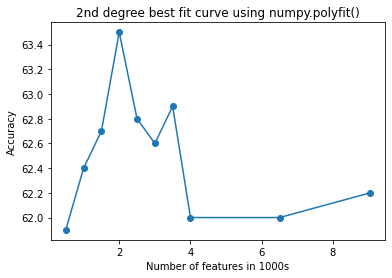

In [ ]:
#. code from https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
# Importing the necessary libraries
from matplotlib import pyplot as plt
import numpy as np

X = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 6.5, 9.043])
y = np.array([61.9, 62.4, 62.7, 63.5, 62.8, 62.6, 62.9, 62.0, 62.0, 62.2])

# Plotting the data points
plt.scatter(X, y)
plt.plot(X, y)
plt.xlabel('Number of features in 1000s')
plt.ylabel('Accuracy')
plt.show()

Graph of accuracy against numbers of features in 1000s.
- Accuracy used since data is balanced.


> Maximum performance occurs at 2000 features for 8000 training instances. Hence, we concluded optimal features would be 25% of training data set.



Text(0.5, 1.0, 'Scores for Sarcastic vs. None-Sarcastic Comments')

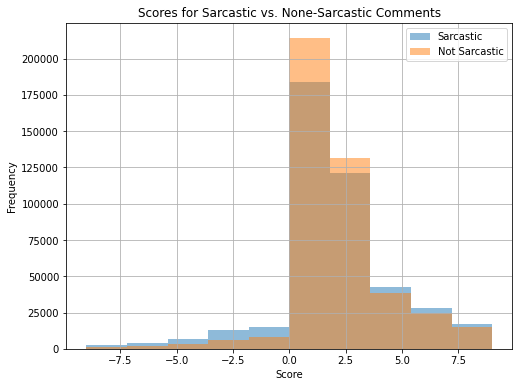

In [ ]:
#code from https://www.kaggle.com/sachinichake/sarcasm-detection
dataframe['score'].min(), dataframe['score'].max()
# Mean and STD of Score Rating
mean = dataframe['score'].mean()
std = dataframe['score'].std()
# Distribution of Scores for Sarcastic and Non-Sarcastic Comments
plt.figure(figsize=(8,6))
dataframe[(dataframe['score'].abs()<(10-((dataframe['score'].abs()-mean)/std))) & (dataframe['label']==1)]['score'].hist(alpha=0.5,label='Sarcastic')
dataframe[(dataframe['score'].abs()<(10-((dataframe['score'].abs()-mean)/std))) & (dataframe['label']==0)]['score'].hist(alpha=0.5,label='Not Sarcastic')
plt.yscale('linear')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.legend()
plt.title('Scores for Sarcastic vs. None-Sarcastic Comments')

Conclusion: Sarcastic comments have more negative scores. Hence, we decided to convert score to binary whereby 0 will be negative score and 1 will be positive score. This is because we decided the sign of the score matters more than the magnitude.

In [ ]:
# code from https://www.kaggle.com/icemtel/a4-sarcasm-detection-exercise
sub_df_subreddit = dataframe_selected.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df_subreddit[sub_df_subreddit['size'] > 100].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,178,0.752809,134
Conservative,137,0.708029,97
niceguys,128,0.687500,88
TwoXChromosomes,156,0.666667,104
italy,112,0.651786,73
EnoughTrumpSpam,579,0.651123,377
worldnews,1930,0.650777,1256
politics,6534,0.643710,4206
fatlogic,150,0.640000,96


In [ ]:
sub_df_subreddit[sub_df_subreddit['size'] > 100].sort_values(by='mean', ascending=True).head(10)

,size,mean,sum
subreddit,,,
me_irl,113,0.132743,15
aww,248,0.318548,79
RocketLeagueExchange,252,0.321429,81
westworld,103,0.330097,34
Eve,118,0.347458,41
fantasyfootball,467,0.368308,172
Jokes,236,0.368644,87
WTF,381,0.383202,146
tifu,125,0.384000,48


In [ ]:
sub_df_subreddit[sub_df_subreddit['size'] < 100].count()

size    5136
mean    5136
sum     5136
dtype: int64

In [ ]:
sub_df_subreddit.count()

size    5294
mean    5294
sum     5294
dtype: int64

In [ ]:
sub_df_subreddit[sub_df_subreddit['size'] > 100].count()

size    157
mean    157
sum     157
dtype: int64

- 
Conclusion: some subreddits are more sarcastic than others as evident from the differing mean. Hence, we hypothesise that subreddits is an important factor in determining whether a comment is sarcastic.

Possible explanation for subreddits not being a good indicative factor would be because only 157 out of 5294 subreddits have more than 100 comments, hence the other 5136 subreddits may not be very representative of their sarcastic nature.  As such, when training the model with such a wide range of subreddits, it may in turn decrease the test accuracy due to bad support vectors trained on the smaller subreddits captured.

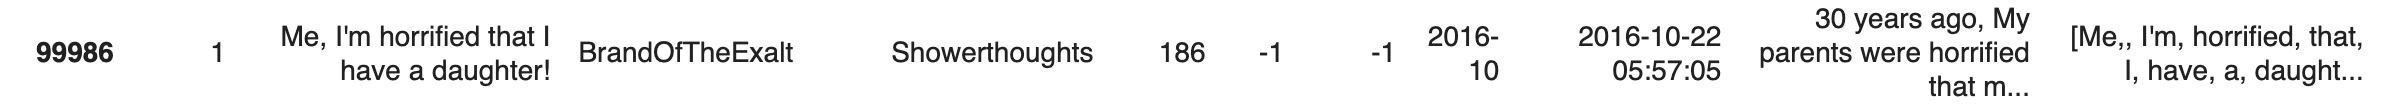

From examining the data closely, we found that exclamation, question and quotation marks are often found in sarcastic comments. Hence, we decided to engineer new features that counts the number of exclamation, question and quotation marks.

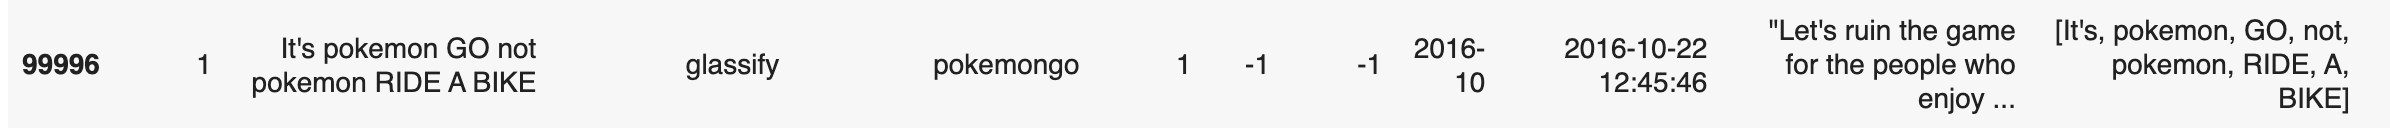

Similarly, we also found that sarcastic portion of the comment are often emphasised with capital letters. Hence, we also included that as an extra feature engineered.

Micro Level Analysis: Instances where the model predicted wrongly
---

In [ ]:
# code referenced from: https://stackoverflow.com/questions/45176469/can-i-get-a-list-of-wrong-predictions-in-scikit-learn
# get first 20 wrong predictions
count = 0
predicted_arr = []
target_arr = []
for row_index, (input, prediction, label) in enumerate(zip(joined_sparse_mat_test.toarray(), predictions_SVM, Test_Y)):
  if prediction != label and count < 20:
    predicted_arr.append(input)
    target_arr.append((row_index, prediction, label))
    count+= 1
pred_df = pd.DataFrame(predicted_arr)
target_df = pd.DataFrame(target_arr)

In [ ]:
pred_df.loc[:, (pred_df != 0).any(axis=0)]

,2,14,46,71,73,77,132,186,194,227,232,233,271,281,284,317,346,538,542,547,572,609,658,677,708,715,724,734,745,763,817,1031,1034,1048,1079,1085,1113,1161,1165,1191,1204,1206,1253,1387,1423,1425,1446,1465,1571,1575,1579,1640,1675,1695,1735,1745,1790,1795,1817,1842,1849,1851,1890,1922,1978,1988,1989,2000,2001,2002
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.844432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.535663,0.324230,-0.367305,-0.189336
1,0.000000,0.346623,0.000000,0.000000,0.366347,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382347,0.000000,0.000000,0.00000,0.000000,0.459374,0.000000,0.000000,0.368397,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.324230,-0.367305,-0.189336
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.402162,0.000000,0.000000,0.000000,0.000000,0.512431,0.000000,0.000000,0.000000,0.000000,0.44374,0.000000,0.323072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.523831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.324230,-0.367305,4.776855
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.084231,-0.367305,-0.189336
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826186,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.563398,0.000000,0.324230,-0.367305,-0.189336
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.452643,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.729038,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.513437,0.000000,0.000000,0.000000,0.

In [ ]:
target_df

,0,1,2
0,0,0,1
1,1,1,0
2,2,1,0
3,4,1,0
4,6,1,0
5,7,0,1
6,8,0,1
7,9,1,0
8,10,1,0
9,12,0,1


Comment: !remind me 10 years; score:1, qn mark: 0, quote mark: 0
- predicted: 0, actual: 1 Analysis: vectoriser only captures the uniqueness of the words. However in this case, the sarcasm stems from overexaggeration of the duration (10 years), since vectorisor is unable to capture the magnitude and meaning of words, it is likely to fail especially when such words are neutral and can be used in both sarcastic and non sarcastic comments. In addition, the comment does not have any qn or quotation marks, which led the model to categorise it as non sarcastic.

Comment: Don't forget fake "whoops your memory card is corrupted"
; score: 1, qn mark: 0, quote mark: 2
- predicted: 1, actual: 0
Analysis: quote mark - predicted as sarcastic, but user was only using it to quote the item

Comment: Even about that round of golf? Score: 1, qn mark: 1, quote mark: 0
- predicted: 1, actual: 0

>Parent Comment: North Korea has never lied. Not once.
>Context: https://golf.com/news/behind-kim-jong-ils-famous-round-of-golf/?amp=1

Analysis: qn mark - predicted as sarcastic. After human inspection, we decided the comment is indeed sarcastic. However, due to quality of dataset whereby it is self labelled as sarcastic by the '/s' tag, some comments may be sarcastic although the author did not include the tag. Hence this introduces stochastic noise in the data.



MEETING NOTES
---

question for prof:
- why does accuracy decrease
- max column/features for tdfif vectoriser -- recommended numbers, and whether it leads to curse of dimensionality [but more for distance-based learners]; [svm already discards
  - **elbow curve** -> to find the most optimum num of features --> test with 5000, plot maxFeatures =  500, 1000, 1500, 2000, 2500, 3000
  - do introspection (to explain this number) --> short data? --> see if you can visualise the vectors; 
  - idf score calculations --> if using large corpus? shows how rare a particular word is ...?
  - what features are being selected by the svm --> requires inspecting the weights, to find the support vectors being used 
    - analyse those and explain why those values chosen
- subreddit as a feature --> is it labelling issue? it decreased our accuracy in the small dataset/ so we didnt include it in large dataset --> but should we still?
  - we think it's quite evident that some subreddits are more sarcastic than the other, eg. politics
  - how to introduce the metadata ,,, ?
  - can you explain why it not be working --> then can you attribute why and show some experiments that why it's not working?
  - https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes 
  - is the coding randomised for each cycle?
  - how does svm interpret the dataset
- cross validation --> how many folds for this amount of data? --> a good number is 5
  -  can also try other numbers, and to explain any performance difference
  - may get different results on different tries - so do a few times for the numbers to stabilise and get the average
  - used for hyperparameter tuning of c value
- how to select regularisation parameters, any recommended readings/ guidelines/ algorithm

meeting 17/11

---

- start the experiement with a hypothesis, then run the model to validate it, then explain the results -> whether it fits the hypothesis
- macro analysis --> f1 or accuracy (like a letter grade for the model)
  - but not good
- meso analysis --> look at individual instances of the dataset, diagnose the issues
  - why this instance don't do well
  - why this subset of instance don't do well
  - show that you understand the biases of this chosen model
- micro analysis
- each model have different optimal setting --> why?
  - do some further readings; what do those ppl do to show this is the case
  - 1. explain the guess
  - 2. do some small experiments to show that's the case -- empirical evidence

- cite the code; show that you understand the code
  - why is it using these support vectors etc ... (for a subset of the data)
- quality of data
- whether classifier thinks its hard to classify and whether we think it's the same
- tune the analysis to that dataset
  - what you know abt the model vs what you know about the dataset.
- observing others' results vs making further analysis of my own 
  - cite if you followed the other experiments/ explain whether you could replicate
- being able to explain why the model is performing as so is more important than the optimising the model performance

meeting 17/11

scientific approach to proj (presentation and report)
hypothesis impact on results —> run experiment to validate

3 lvls of analysis
- macro: F1 accuracy, model good or bad
- micro: sub population of data —> look at instances of dataset (explain why, find other instances like this one and see if it also doesnt do well) [similar to assignment 1]
    - use data set to analyse how model is doing instead of a singular value of measurement
    - understand the ml model bias

graph —> decreasing increase in performance as no. of features increase
svm less affected by num of features —> only depends on the support vectors at the decision boundaries
think about what features captured by svm, linear kernal, pick out which words are active in model by inspecting the weights

data quality issues —> some we find are not sarcastic 
=> try it out ourselves, if we perform badly link to quality of data

idf scores will be more representative—> comments are short, better capture the frequency rarity of other words. rarer —> more significant impact